# Visualization of Trading Results with Trade Points

This notebook creates a comprehensive visualization of trading results, comparing the FinRL agent's performance against a buy-and-hold strategy. It plots cumulative returns and marks the points where trades occurred.

## Important Note
This visualization script requires manual adjustment of data loading paths for different agents and strategies:
```python
# Example path structure:
'results/{strategy_number}. {symbol}/{symbol}_{agent_type}_df_account_value_{model}.pkl'
'results/{strategy_number}. {symbol}/{symbol}_{agent_type}_df_actions_{model}.pkl'
'results/{strategy_number}. {symbol}/{symbol}_{agent_type}_buy_and_hold.pkl'
```
The script must be run separately for each agent by updating these paths accordingly.

## Features
1. Cumulative return comparison between FinRL agent and buy-and-hold
2. Trade point visualization (buy/sell markers)
3. Volume visualization in a separate panel
4. Custom color scheme for better readability

## Data Sources
- Agent's account value history (`df_account_value_*.pkl`)
- Trade actions (`df_actions_*.pkl`)
- Buy-and-hold benchmark data (`buy_and_hold.pkl`)

## Visualization Components
- Main panel: Cumulative returns (%)
- Secondary panel: Trading volume
- Markers: Green triangles (▲) for buys, Red triangles (▼) for sells
- Legend: FinRL strategy, Buy & Hold, Buy points, Sell points

In [8]:
import pandas as pd
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import pickle

### Load Data

In [9]:
# Load agent's account value history
with open('results/1. AAPL/aapl_finrl_df_account_value_ppo.pkl', 'rb') as f:
    df_account_value = pickle.load(f)

# Load agent's trading actions
with open('results/1. AAPL/aapl_finrl_df_actions_ppo.pkl', 'rb') as f:
    df_actions = pickle.load(f)

# Load buy-and-hold benchmark data
with open('results/1. AAPL/aapl_finrl_buy_and_hold.pkl', 'rb') as f:
    buy_and_hold = pickle.load(f)

### Create Plot with Trade Points

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_20324/1031772043.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


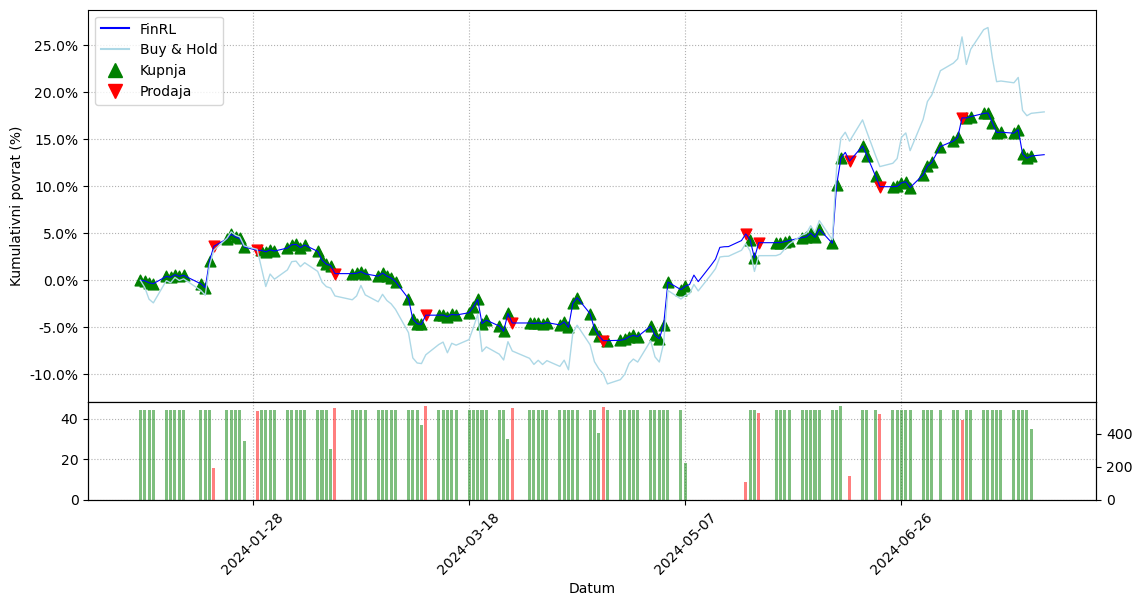

In [11]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for mplfinance
df = df_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Calculate cumulative returns for FinRL strategy
initial_value_ppo = df['account_value'].iloc[0]
df['cumulative_return'] = (df['account_value'] / initial_value_ppo - 1) * 100
df['Open'] = df['Close'] = df['High'] = df['Low'] = df['cumulative_return']
df['Volume'] = 0

# Mark buy/sell points and set volume
df.loc[df_actions.index, 'Volume'] = df_actions['actions'].apply(lambda x: abs(x[0]))
buys = pd.Series(False, index=df.index)
sells = pd.Series(False, index=df.index)
buys.loc[df_actions[df_actions['actions'].apply(lambda x: x[0] > 0)].index] = True
sells.loc[df_actions[df_actions['actions'].apply(lambda x: x[0] < 0)].index] = True

# Set plot style
mc = mpf.make_marketcolors(up='g', down='r', volume='inherit', edge='inherit', wick='inherit')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', y_on_right=False)

# Prepare buy-and-hold data
buy_and_hold.index = pd.to_datetime(buy_and_hold.index)
buy_and_hold = buy_and_hold.reindex(df.index).ffill()

# Calculate cumulative returns for buy-and-hold
initial_value_bh = buy_and_hold['close'].iloc[0]
buy_and_hold['cumulative_return'] = (buy_and_hold['close'] / initial_value_bh - 1) * 100

# Define colors
ppo_color = 'blue'
buy_hold_color = 'lightblue'

# Create additional plots
apds = [
    mpf.make_addplot(df['Close'].where(buys), type='scatter', markersize=60, marker='^', color='g'),
    mpf.make_addplot(df['Close'].where(sells), type='scatter', markersize=60, marker='v', color='r'),
    mpf.make_addplot(df['Volume'].where(buys), type='bar', width=0.7, panel=1, color='g', alpha=0.5),
    mpf.make_addplot(df['Volume'].where(sells), type='bar', width=0.7, panel=1, color='r', alpha=0.5),
    mpf.make_addplot(df['Volume'].where(~buys & ~sells), type='bar', width=0.7, panel=1, color='gray', alpha=0.5),
    mpf.make_addplot(buy_and_hold['cumulative_return'], color=buy_hold_color, width=1, label='Buy & Hold')
]

# Create the plot
fig, axes = mpf.plot(df, type='line', style=s, addplot=apds,
                     xlabel='Datum', ylabel='Kumulativni povrat (%)',
                     figsize=(14, 7), panel_ratios=(4,1), xrotation=45,
                     tight_layout=False, show_nontrading=True,
                     datetime_format='%Y-%m-%d', volume=False, returnfig=True,
                     linecolor=ppo_color)  # Postavljamo boju PPO linije

# Add legend
legend_elements = [
    plt.Line2D([], [], color=ppo_color, label='FinRL'),
    plt.Line2D([], [], color=buy_hold_color, label='Buy & Hold'),
    plt.Line2D([], [], marker='^', color='g', linestyle='None', markersize=10, label='Kupnja'),
    plt.Line2D([], [], marker='v', color='r', linestyle='None', markersize=10, label='Prodaja')
]
axes[0].legend(handles=legend_elements, loc='upper left')

# Format y-axis to show percentages
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

# Adjust layout and display
plt.tight_layout()
plt.show()